# Clump Volume Distributions vs. Resolution (snap = 35)

This notebook compares cumulative clump volume distributions across grid resolutions for the snap 35 outputs. The datasets listed below were generated with connectivity 6 and a temperature threshold of 0.10, so the comparison isolates resolution effects. You can extend the mapping if additional runs become available (for example, higher resolution data with matching thresholds).

In [1]:
from pathlib import Path

import numpy as np
import matplotlib
matplotlib.rc('font', family='serif')
matplotlib.rc('mathtext', fontset='cm')
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['lines.dash_capstyle'] = 'round'
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cmasher as cmr



In [2]:
BASE_PATH = Path('..').resolve()

DATASETS = {
    320: {
        'path': BASE_PATH / 'clump_out/n320_sweep/conn6_T0p02_step00036/clumps_stitched.npz',
        'temperature_threshold': 0.10,
        'connectivity': 6,
    },
    640: {
        'path': BASE_PATH / 'clump_out/n640_sweep/conn6_T0p02_step00036/clumps_stitched.npz',
        'temperature_threshold': 0.10,
        'connectivity': 6,
    },
    1280: {
        'path': BASE_PATH / 'clump_out/n1280_sweep/conn6_T0p02_step00036/clumps_stitched.npz',
        'temperature_threshold': 0.10,
        'connectivity': 6,
    },
    2560: {
        'path': BASE_PATH / 'clump_out/n2560_sweep/conn6_T0p02_step00036/clumps_stitched.npz',
        'temperature_threshold': 0.10,
        'connectivity': 6,
    },
    5120: {
        'path': BASE_PATH / 'clump_out/n5120_sweep/conn6_T0p02_step00036/clumps_stitched.npz',
        'temperature_threshold': 0.10,
        'connectivity': 6,
    },
    10240: {
        'path': BASE_PATH / 'clump_out/n10240_sweep/conn6_T0p02_step00036/clumps_stitched.npz',
        'temperature_threshold': 0.10,
        'connectivity': 6,
    },
}

sorted_resolutions = tuple(sorted(DATASETS))
sorted_resolutions

(320, 640, 1280, 2560, 5120, 10240)

In [3]:
def load_clump_volumes(path):
    '''Return raw clump volumes and cell counts from a NumPy archive.'''
    with np.load(path) as data:
        volumes = data['volume']
        if 'cell_count' in data:
            cell_counts = data['cell_count']
        else:
            cell_counts = data['num_cells']
    return volumes.astype(np.float64), cell_counts.astype(np.int64)


def prepare_distributions(resolution, info):
    volumes, cell_counts = load_clump_volumes(info['path'])
    if volumes.size == 0:
        raise ValueError(f'No clumps found for resolution {resolution}')

    cell_volume = float(np.median(volumes / np.maximum(cell_counts, 1)))
    dx = cell_volume ** (1.0 / 3.0)
    box_length = dx * resolution
    box_volume = box_length ** 3

    volumes_sorted = np.sort(volumes)
    ranks = np.arange(volumes_sorted.size, 0, -1)

    volumes_dx = volumes_sorted / cell_volume
    volumes_box = volumes_sorted / box_volume

    vn_dx = volumes_dx * ranks
    vn_box = volumes_box * ranks

    summary = {
        'resolution': resolution,
        'temperature_threshold': info['temperature_threshold'],
        'connectivity': info['connectivity'],
        'count': int(volumes.size),
        'dx': dx,
        'cell_volume': cell_volume,
        'box_length': box_length,
        'box_volume': box_volume,
        'volumes_dx': volumes_dx,
        'volumes_box': volumes_box,
        'counts': ranks,
        'vn_dx': vn_dx,
        'vn_box': vn_box,
    }
    return summary

In [4]:
summaries = {
    res: prepare_distributions(res, cfg)
    for res, cfg in DATASETS.items()
}

for res in sorted_resolutions:
    meta = summaries[res]
    print(
        f"N={res:5d} | clumps={meta['count']:7d} | "
        f"dx={meta['dx']:.3e} | L={meta['box_length']:.3f} | "
        f"T={meta['temperature_threshold']:.2f}, conn={meta['connectivity']}"
    )

N=  320 | clumps=   2694 | dx=3.125e-03 | L=1.000 | T=0.10, conn=6
N=  640 | clumps=  10949 | dx=1.563e-03 | L=1.000 | T=0.10, conn=6
N= 1280 | clumps=  52564 | dx=7.813e-04 | L=1.000 | T=0.10, conn=6
N= 2560 | clumps= 139159 | dx=3.906e-04 | L=1.000 | T=0.10, conn=6
N= 5120 | clumps= 479533 | dx=1.953e-04 | L=1.000 | T=0.10, conn=6
N=10240 | clumps=2283524 | dx=9.766e-05 | L=1.000 | T=0.10, conn=6


In [5]:
meta['counts']

array([2283524, 2283523, 2283522, ...,       3,       2,       1],
      shape=(2283524,))

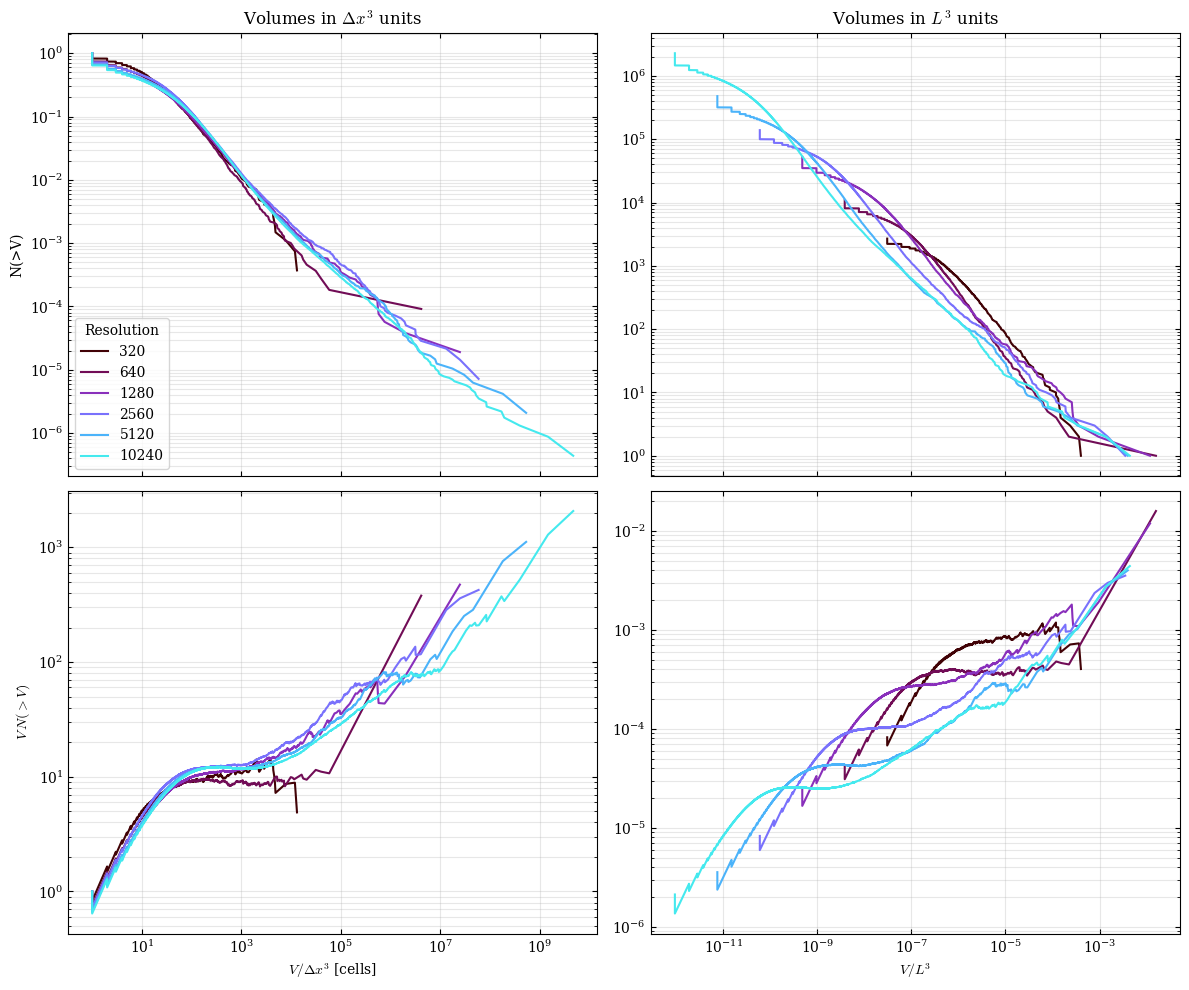

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex='col')

for res in sorted_resolutions:
    meta = summaries[res]
    label = f'{res}'
    color=cmr.gem((np.log10(res) - np.log10(sorted_resolutions[0])) /
                         (np.log10(sorted_resolutions[-1]) - np.log10(sorted_resolutions[0])))

    axes[0, 0].plot(meta['volumes_dx'], meta['counts']/meta['counts'][0], label=label, color=color)
    axes[1, 0].plot(meta['volumes_dx'], meta['vn_dx']/meta['counts'][0], label=label, color=color)

    axes[0, 1].plot(meta['volumes_box'], meta['counts'], label=label, color=color)
    axes[1, 1].plot(meta['volumes_box'], meta['vn_box'], label=label, color=color)

axes[0, 0].set_xscale('log')
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylabel('N(>V)')
axes[0, 0].set_title('Volumes in $\Delta x^3$ units')

axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')
axes[1, 0].set_ylabel('$V\,N(>V)$')
axes[1, 0].set_xlabel('$V / \Delta x^3$ [cells]')

axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Volumes in $L^3$ units')

axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')
axes[1, 1].set_xlabel('$V / L^3$')

for ax in axes.flat:
    ax.grid(True, which='both', alpha=0.3)

axes[0, 0].legend(title='Resolution', loc='lower left')

fig.tight_layout()
plt.show()

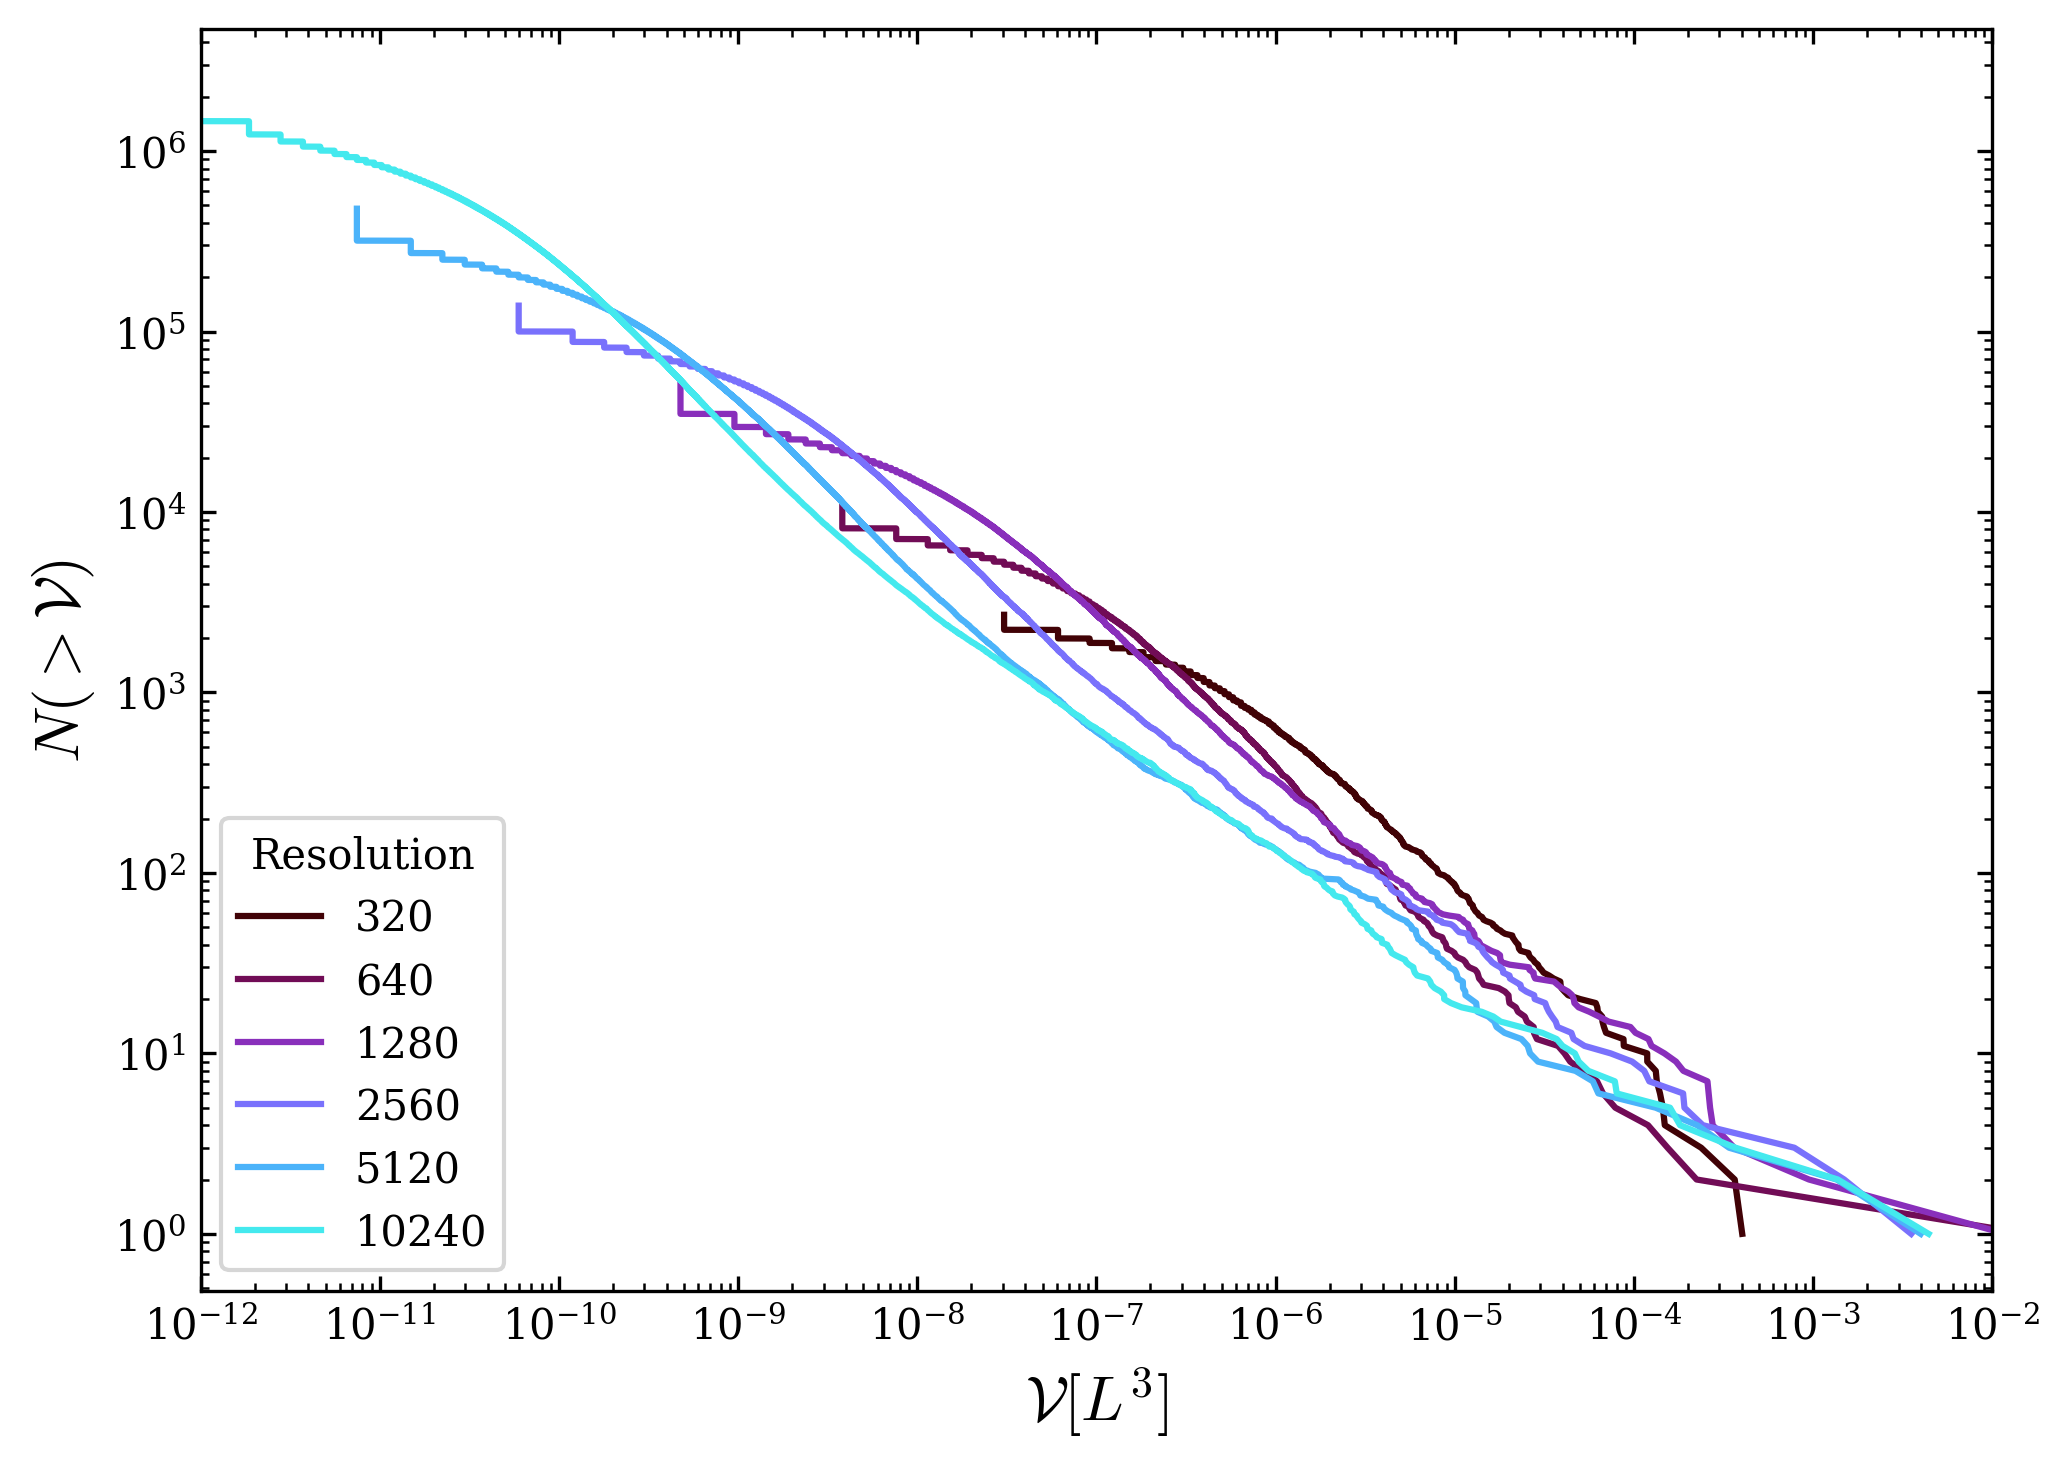

In [17]:
import matplotlib.ticker as mticker


fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=300)

for res in sorted_resolutions:
    meta = summaries[res]
    label = f'{res}'
    color=cmr.gem((np.log10(res) - np.log10(sorted_resolutions[0])) /
                         (np.log10(sorted_resolutions[-1]) - np.log10(sorted_resolutions[0])))

    ax.plot(meta['volumes_box'], meta['counts'], label=label, color=color)

# ax.set_xlim(8, 8e9)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$N(>\mathcal{V})$', fontsize=15)
ax.set_xlabel(r'$\mathcal{V} [L^3]$', fontsize=15)
ax.legend(title='Resolution', loc='lower left')


ax.xaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2, 10)*0.1, numticks=12))
ax.xaxis.set_minor_formatter(mticker.NullFormatter())
ax.set_xticks(10.**np.arange(-12,0,1))

ax.set_xlim(1e-12, 1e-2)

fig.tight_layout()
plt.show()

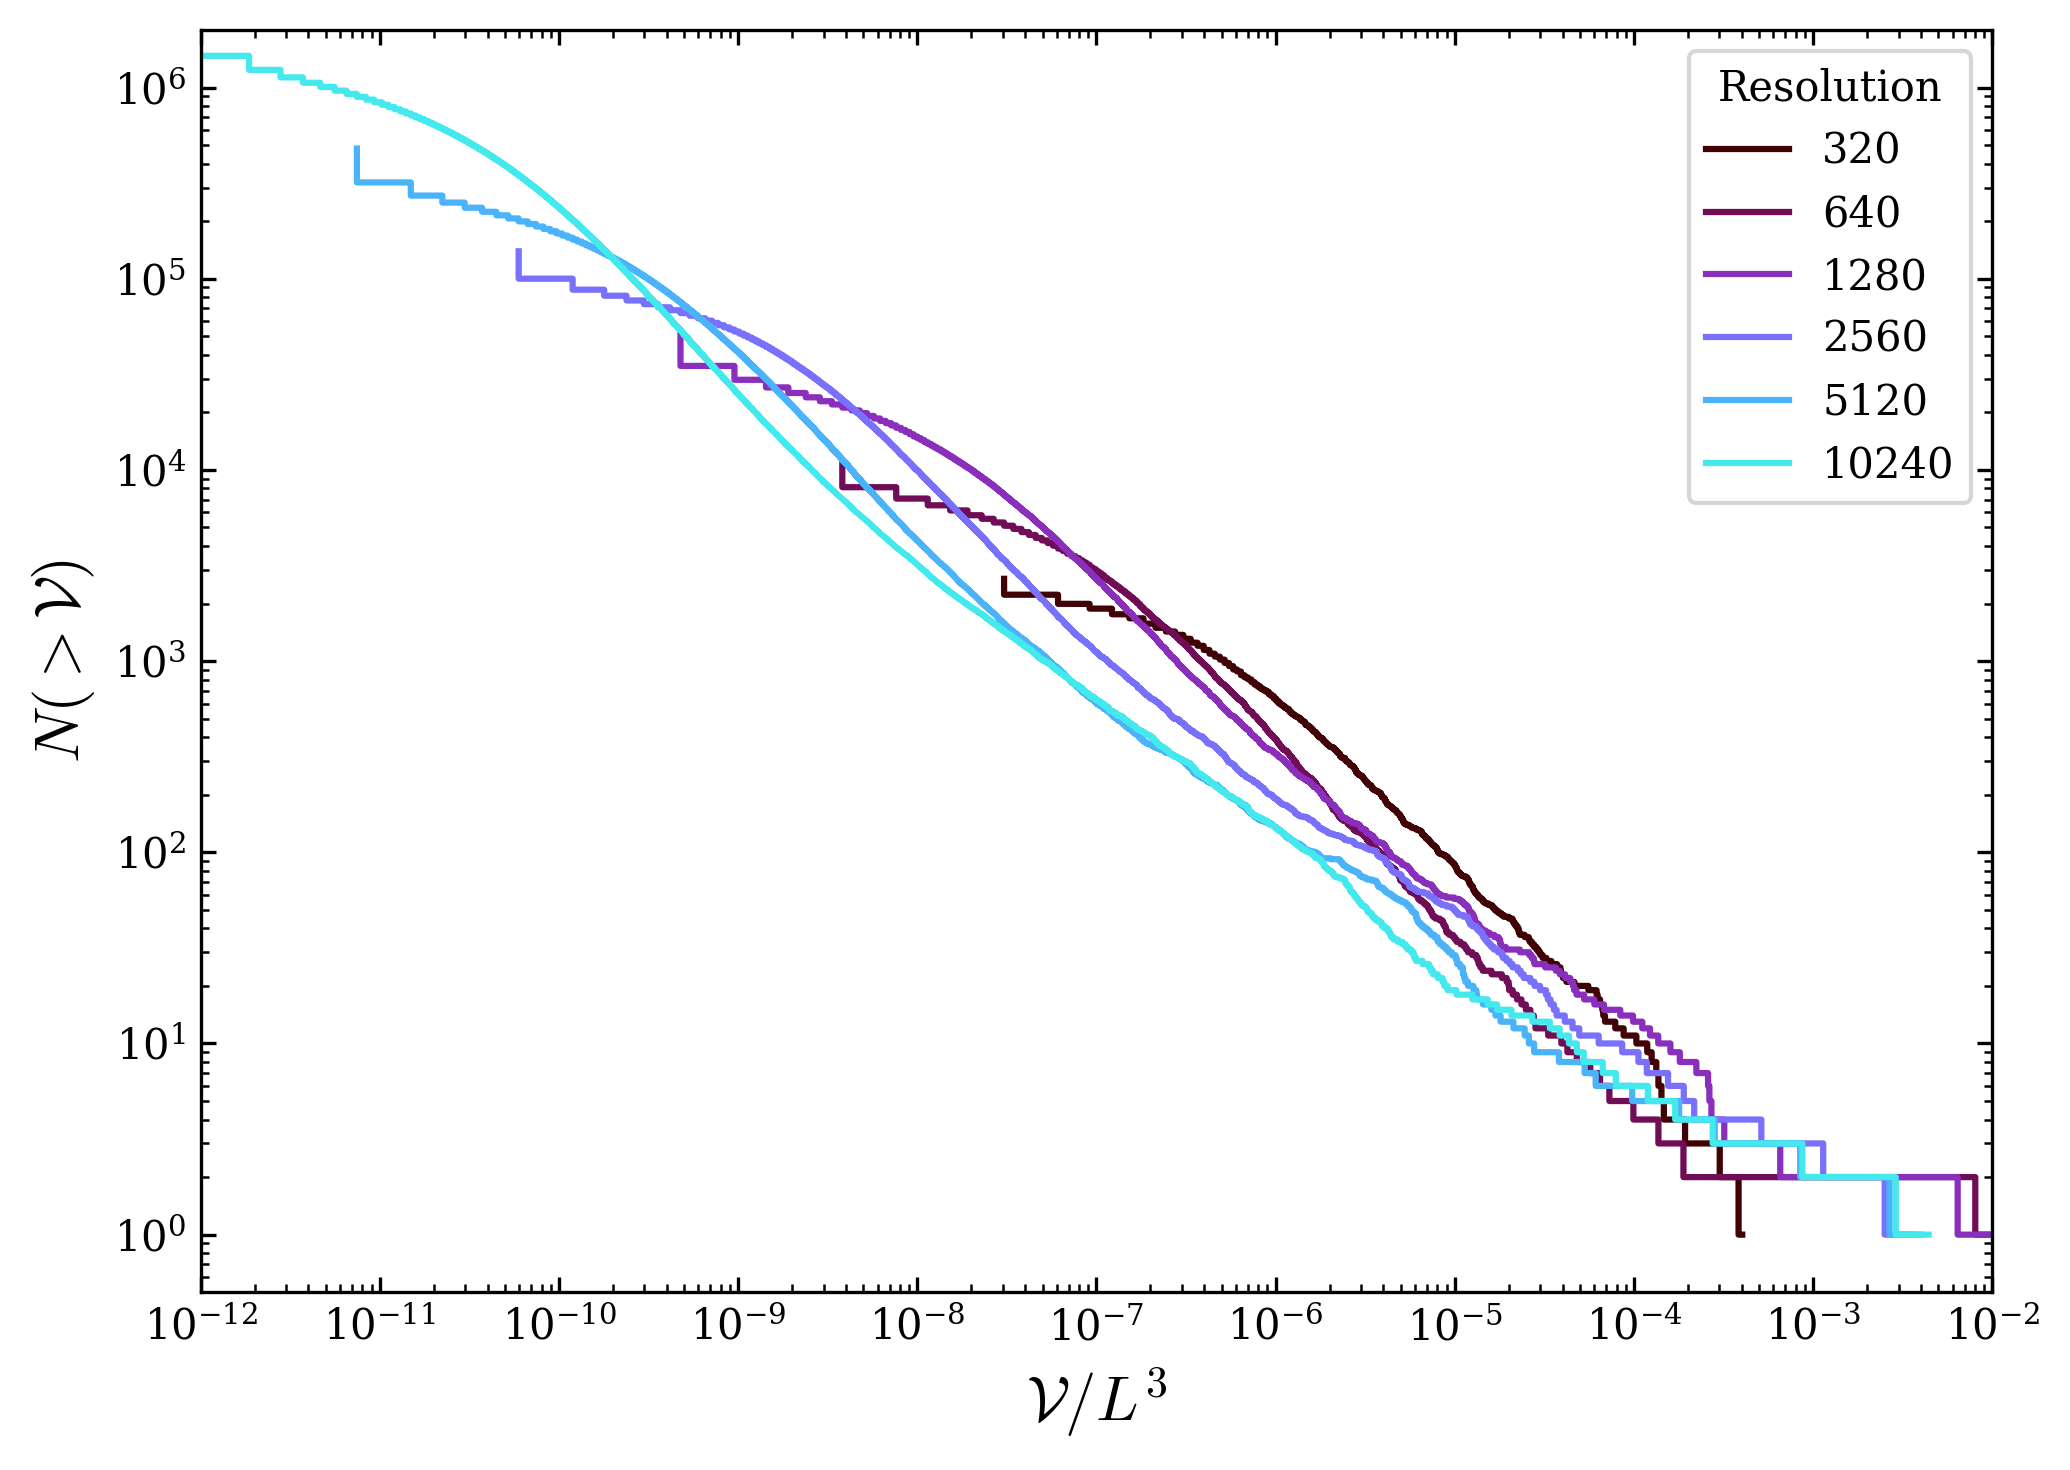

In [61]:
from pathlib import Path
import matplotlib.ticker as mticker

build_dir = Path("plots/build_up")
build_dir.mkdir(parents=True, exist_ok=True)

series = []
for res in sorted_resolutions:
    meta = summaries[res]
    color = cmr.gem(
        (np.log10(res) - np.log10(sorted_resolutions[0]))
        / (np.log10(sorted_resolutions[-1]) - np.log10(sorted_resolutions[0]))
    )
    series.append(
        {
            "label": f"{res}",
            "volumes": meta["volumes_box"],
            "counts": meta["counts"],
            "color": color,
        }
    )

fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=300)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\mathcal{V} / L^3$", fontsize=15)
ax.set_ylabel(r"$N(>\mathcal{V})$", fontsize=15)

major_ticks = 10.0 ** np.arange(-12, 0, 1)

ax.xaxis.set_major_locator(mticker.FixedLocator(major_ticks))
ax.xaxis.set_major_formatter(mticker.LogFormatterSciNotation())

ax.xaxis.set_minor_locator(
    mticker.LogLocator(base=10, subs=np.arange(2, 10) * 0.1, numticks=100)
)
ax.xaxis.set_minor_formatter(mticker.NullFormatter())
ax.tick_params(axis="x", which="minor", length=2)

ax.set_xlim(1e-12, 1e-2)
ax.set_ylim(0.5, 2e6)  # adjust if you want a tighter y-range


for idx, entry in enumerate(series, start=1):
    ax.step(
        entry["volumes"],
        entry["counts"],
        label=entry["label"],
        color=entry["color"],
        where='mid',
    )
    ax.legend(title="Resolution", loc="upper right")
    fig.tight_layout()
    fig.savefig(build_dir / f"clump_cdf_build_{idx:02d}.png", dpi=300)

plt.show()


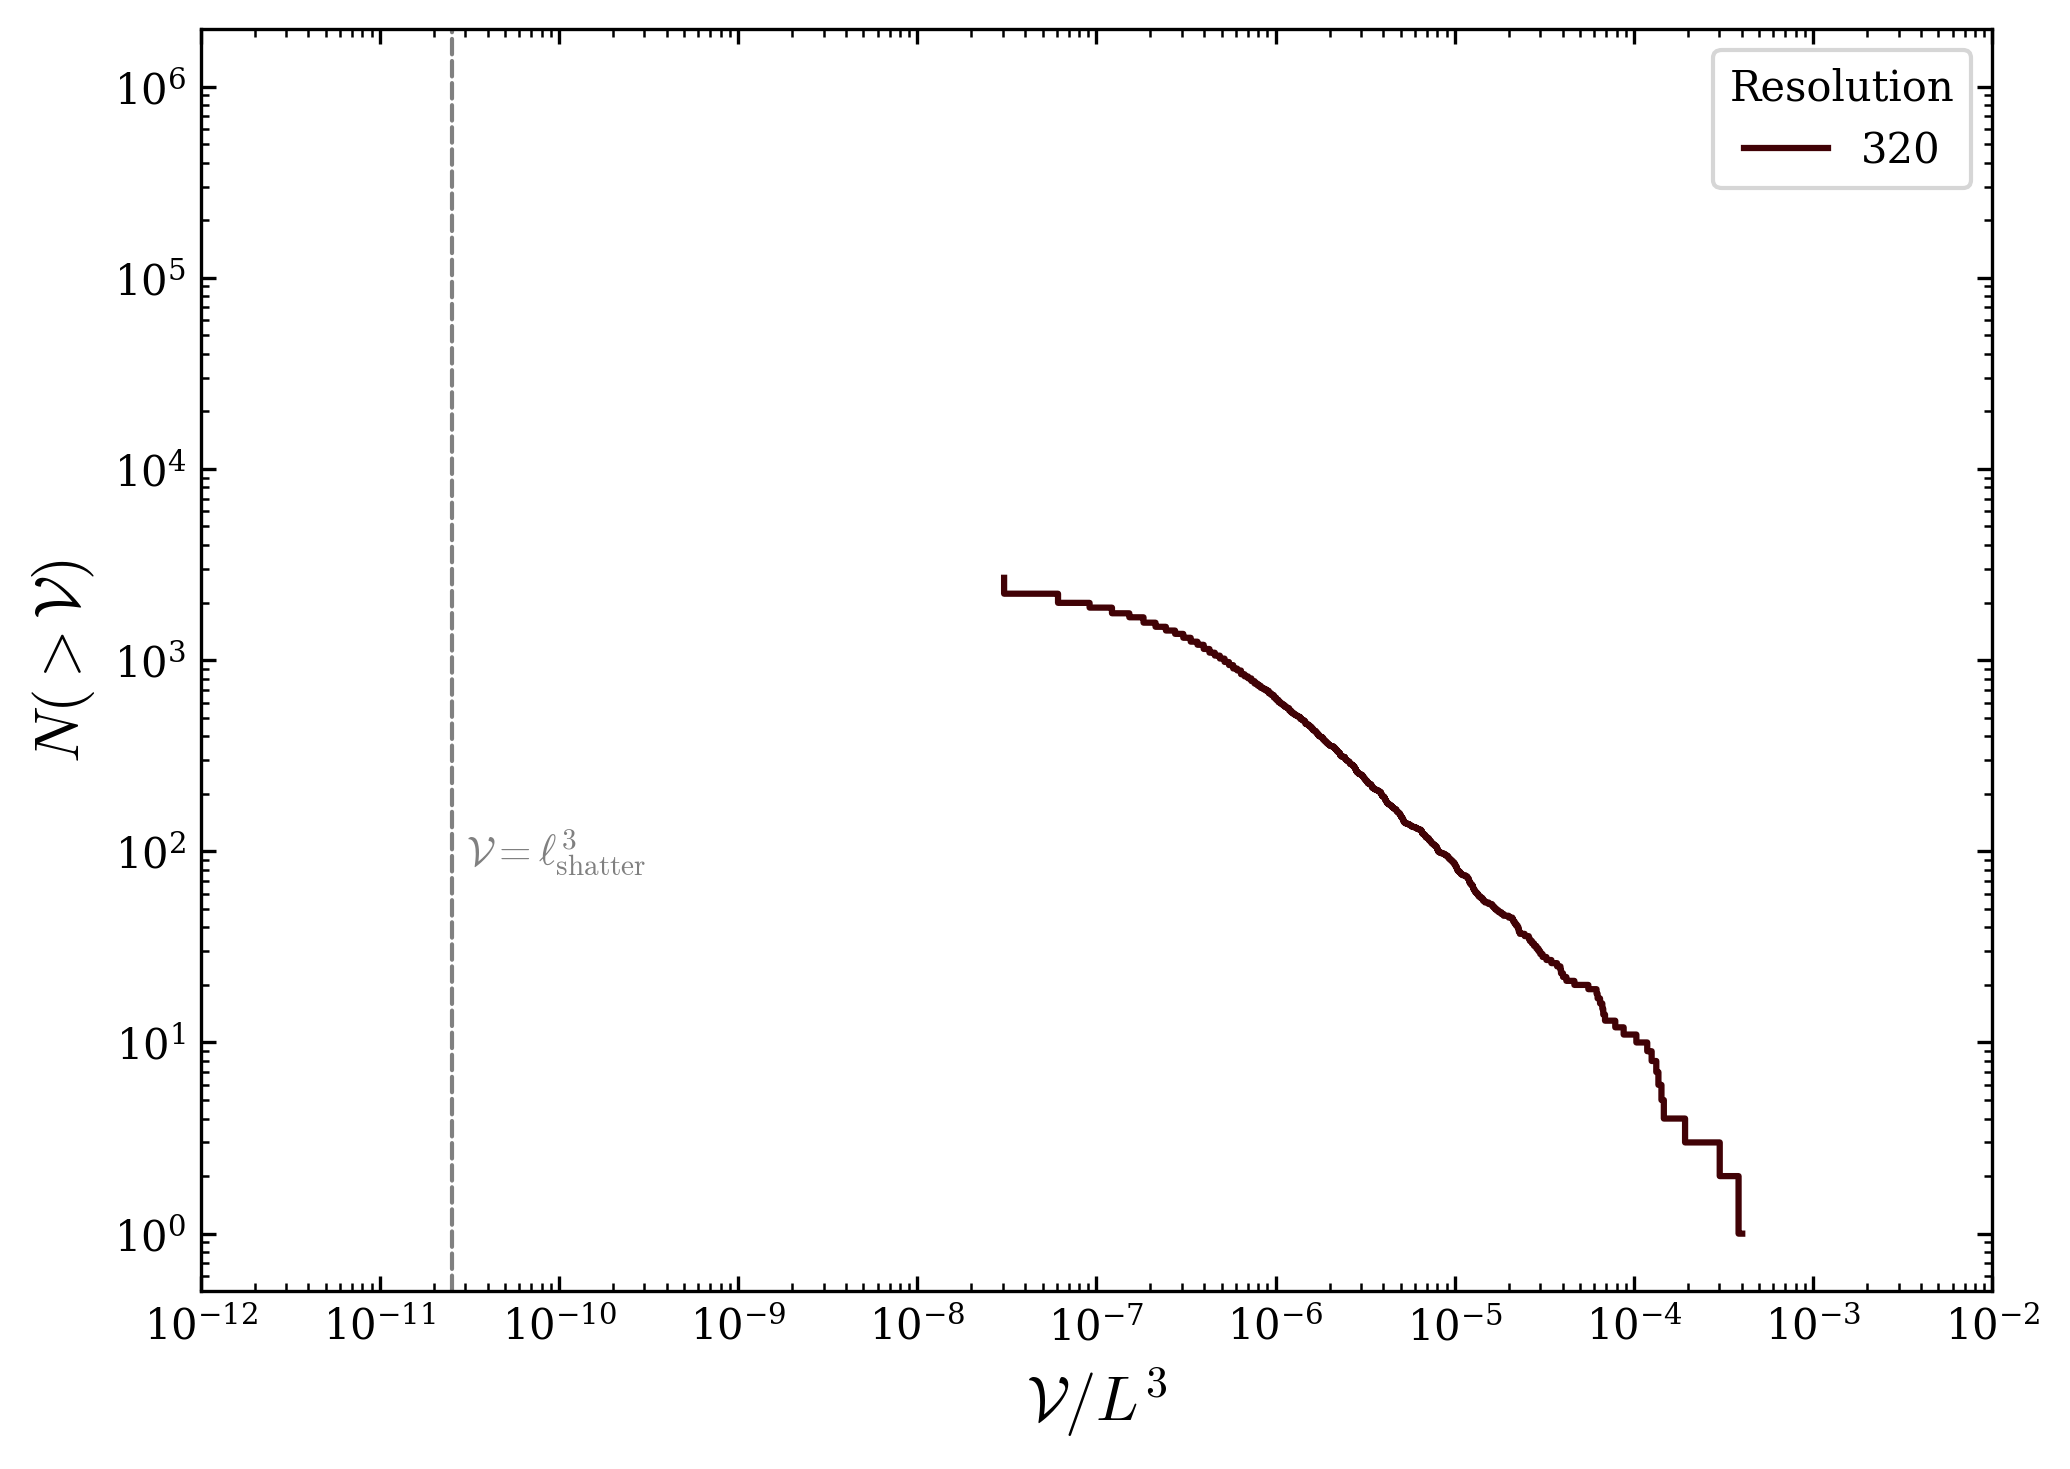

In [62]:
build_dir = Path("plots/build_up")
build_dir.mkdir(parents=True, exist_ok=True)

series = []
for res in sorted_resolutions:
    meta = summaries[res]
    color = cmr.gem(
        (np.log10(res) - np.log10(sorted_resolutions[0]))
        / (np.log10(sorted_resolutions[-1]) - np.log10(sorted_resolutions[0]))
    )
    series.append(
        {
            "label": f"{res}",
            "volumes": meta["volumes_box"],
            "counts": meta["counts"],
            "color": color,
        }
    )

fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=300)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\mathcal{V} / L^3$", fontsize=15)
ax.set_ylabel(r"$N(>\mathcal{V})$", fontsize=15)

major_ticks = 10.0 ** np.arange(-12, 0, 1)

ax.xaxis.set_major_locator(mticker.FixedLocator(major_ticks))
ax.xaxis.set_major_formatter(mticker.LogFormatterSciNotation())

ax.xaxis.set_minor_locator(
    mticker.LogLocator(base=10, subs=np.arange(2, 10) * 0.1, numticks=100)
)
ax.xaxis.set_minor_formatter(mticker.NullFormatter())
ax.tick_params(axis="x", which="minor", length=2)

ax.set_xlim(1e-12, 1e-2)
ax.set_ylim(0.5, 2e6)  # adjust if you want a tighter y-range


for idx, entry in enumerate(series, start=1):
    ax.step(
        entry["volumes"],
        entry["counts"],
        label=entry["label"],
        color=entry["color"],
        where='mid',
    )
    ax.legend(title="Resolution", loc="upper right")
    fig.tight_layout()
    ax.axvline((3/10240)**3, color='gray', linestyle='--', linewidth=1)
    ax.text((3/10240)**3*1.2, 1e2, r'$\mathcal{V} = \ell_{\rm shatter}^3$', color='gray', fontsize=10, va='center')
    fig.savefig(build_dir / f"clump_cdf_build_{idx:02d}_ell_shatter.png", dpi=300)
    plt.show()


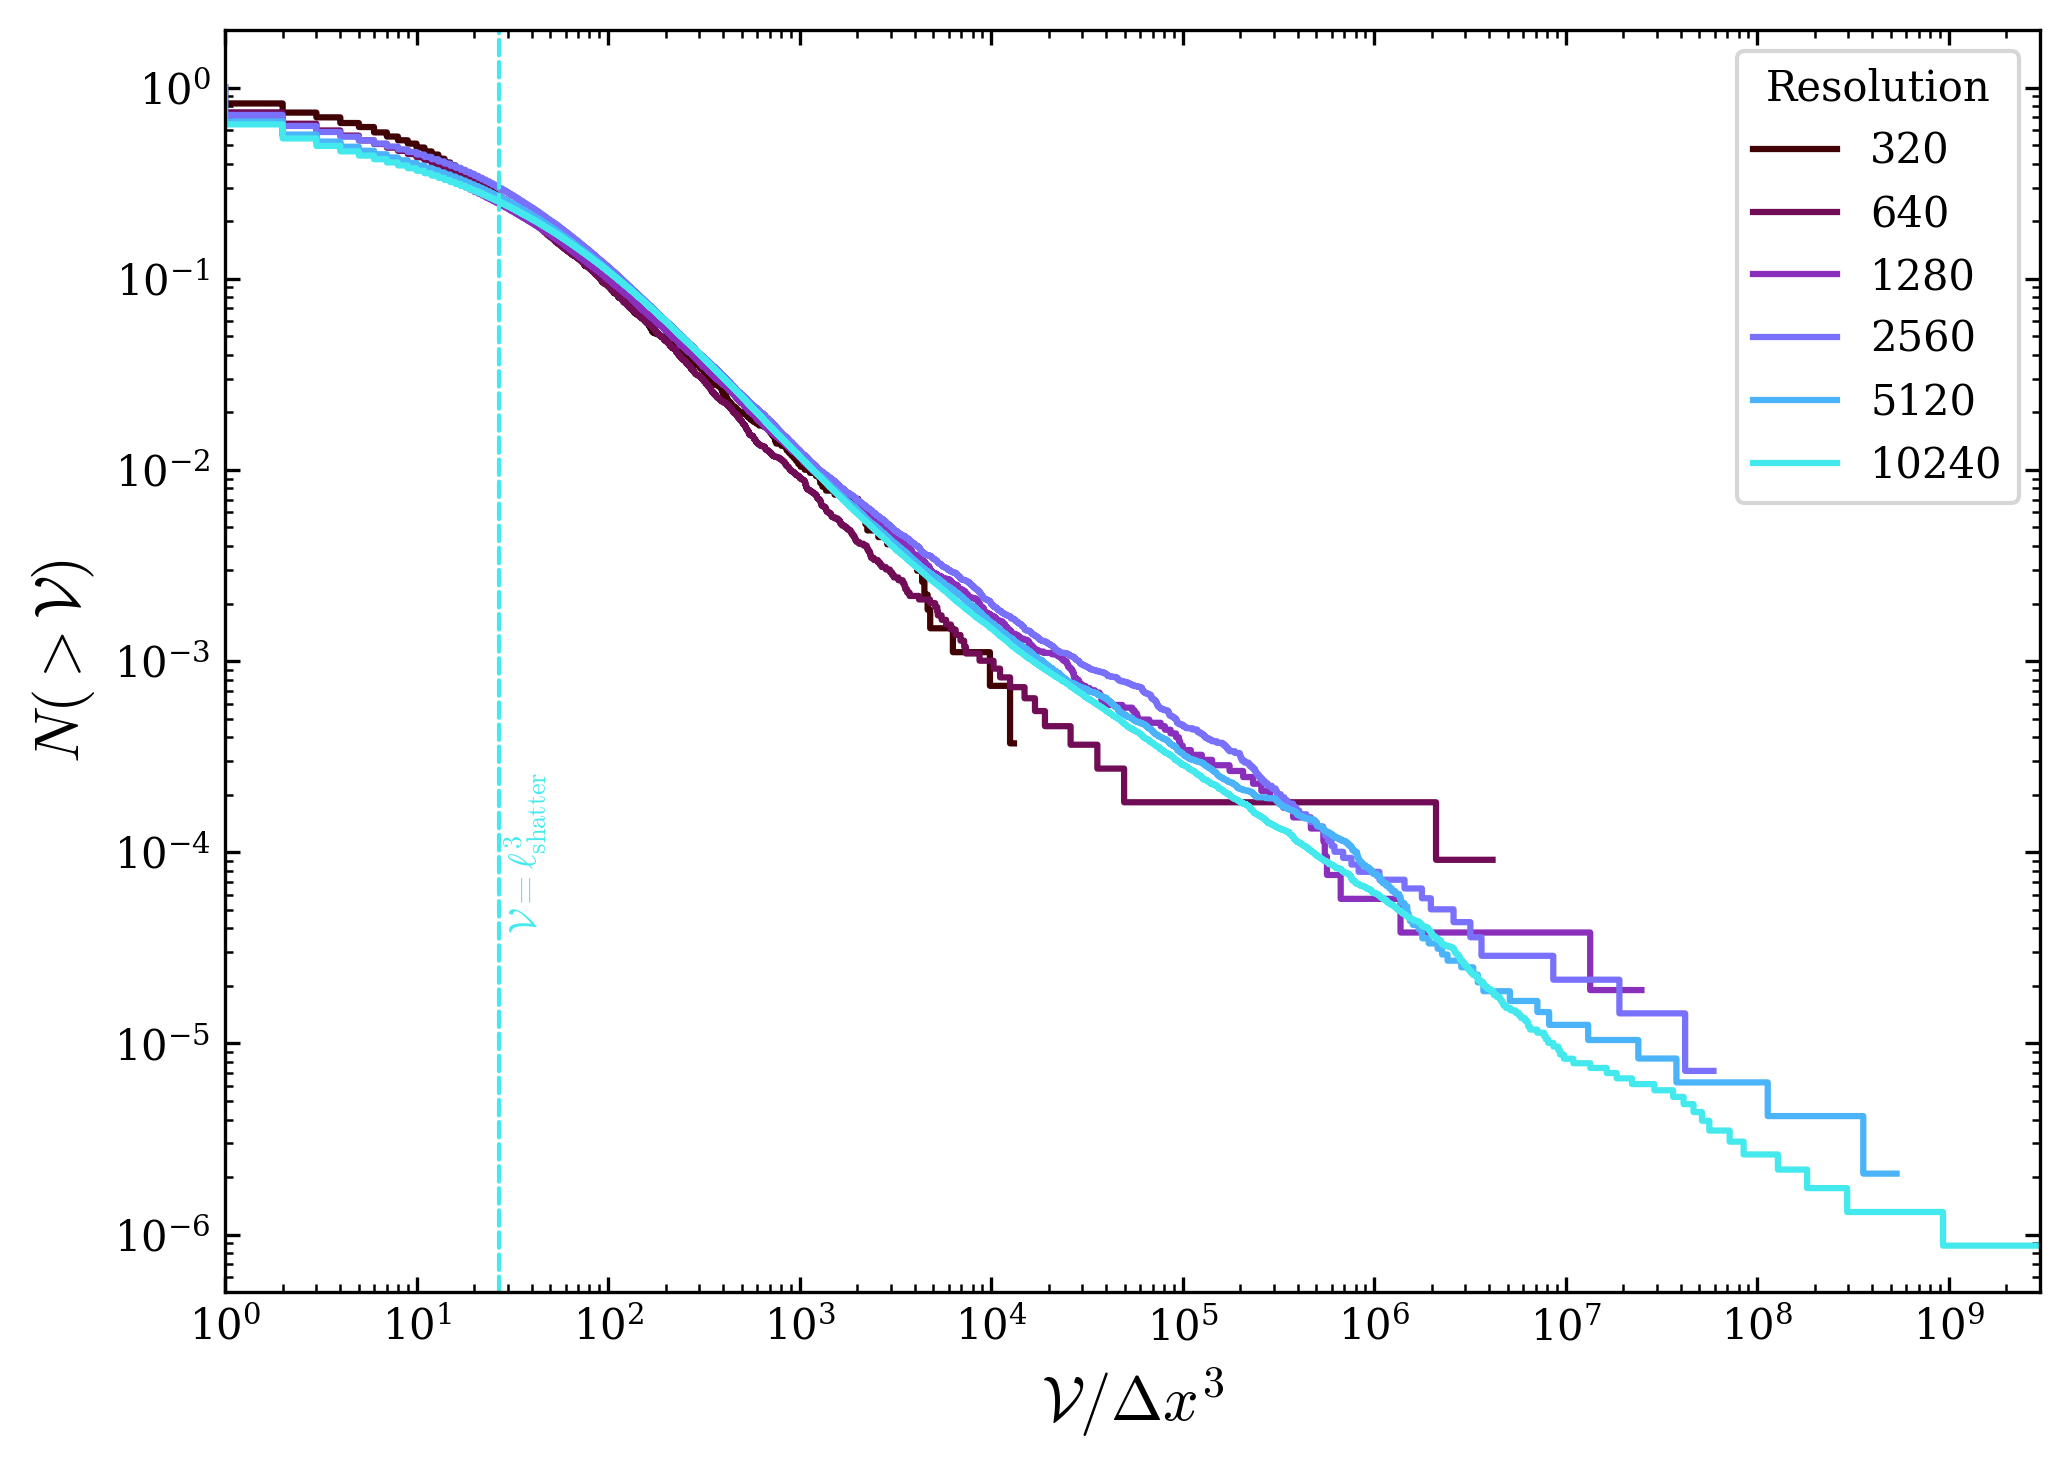

In [58]:
from pathlib import Path
import matplotlib.ticker as mticker

build_dir = Path("plots/build_up")
build_dir.mkdir(parents=True, exist_ok=True)

series = []
for res in sorted_resolutions:
    meta = summaries[res]
    color = cmr.gem(
        (np.log10(res) - np.log10(sorted_resolutions[0]))
        / (np.log10(sorted_resolutions[-1]) - np.log10(sorted_resolutions[0]))
    )
    series.append(
        {
            "label": f"{res}",
            "volumes": meta["volumes_dx"],
            "counts": meta["counts"]/meta["counts"][0],
            "color": color,
            "res": res,
        }
    )

fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=300)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\mathcal{V} / \Delta x^3$", fontsize=15)
ax.set_ylabel(r"$N(>\mathcal{V})$", fontsize=15)

major_ticks = 10.0 ** np.arange(0, 9.1, 1)

ax.xaxis.set_major_locator(mticker.FixedLocator(major_ticks))
ax.xaxis.set_major_formatter(mticker.LogFormatterSciNotation())

ax.xaxis.set_minor_locator(
    mticker.LogLocator(base=10, subs=np.arange(2, 10) * 0.1, numticks=100)
)
ax.xaxis.set_minor_formatter(mticker.NullFormatter())
ax.tick_params(axis="x", which="minor", length=2)

ax.set_xlim(1,3e9)
ax.set_ylim(0.5e-6, 2)  # adjust if you want a tighter y-range


for idx, entry in enumerate(series, start=1):
    ax.step(
        entry["volumes"],
        entry["counts"],
        label=entry["label"],
        color=entry["color"],
        where='mid',
    )
    ax.legend(title="Resolution", loc="upper right")
    fig.tight_layout()
    fig.savefig(build_dir / f"clump_cdf_deltax_build_{idx:02d}.png", dpi=300)
    if entry["res"] == 10240:
        ax.axvline((3*10240/entry["res"])**3, color=entry['color'], linestyle='--', linewidth=1)
        ax.text((3*10240/entry["res"])**3*1.05, 1e-4, r'$\mathcal{V} = \ell_{\rm shatter}^3$', color=entry['color'], fontsize=9, va='center', rotation=90)
        fig.savefig(build_dir / f"clump_cdf_deltax_build_{idx:02d}_ell_shatter.png", dpi=300)

plt.show()


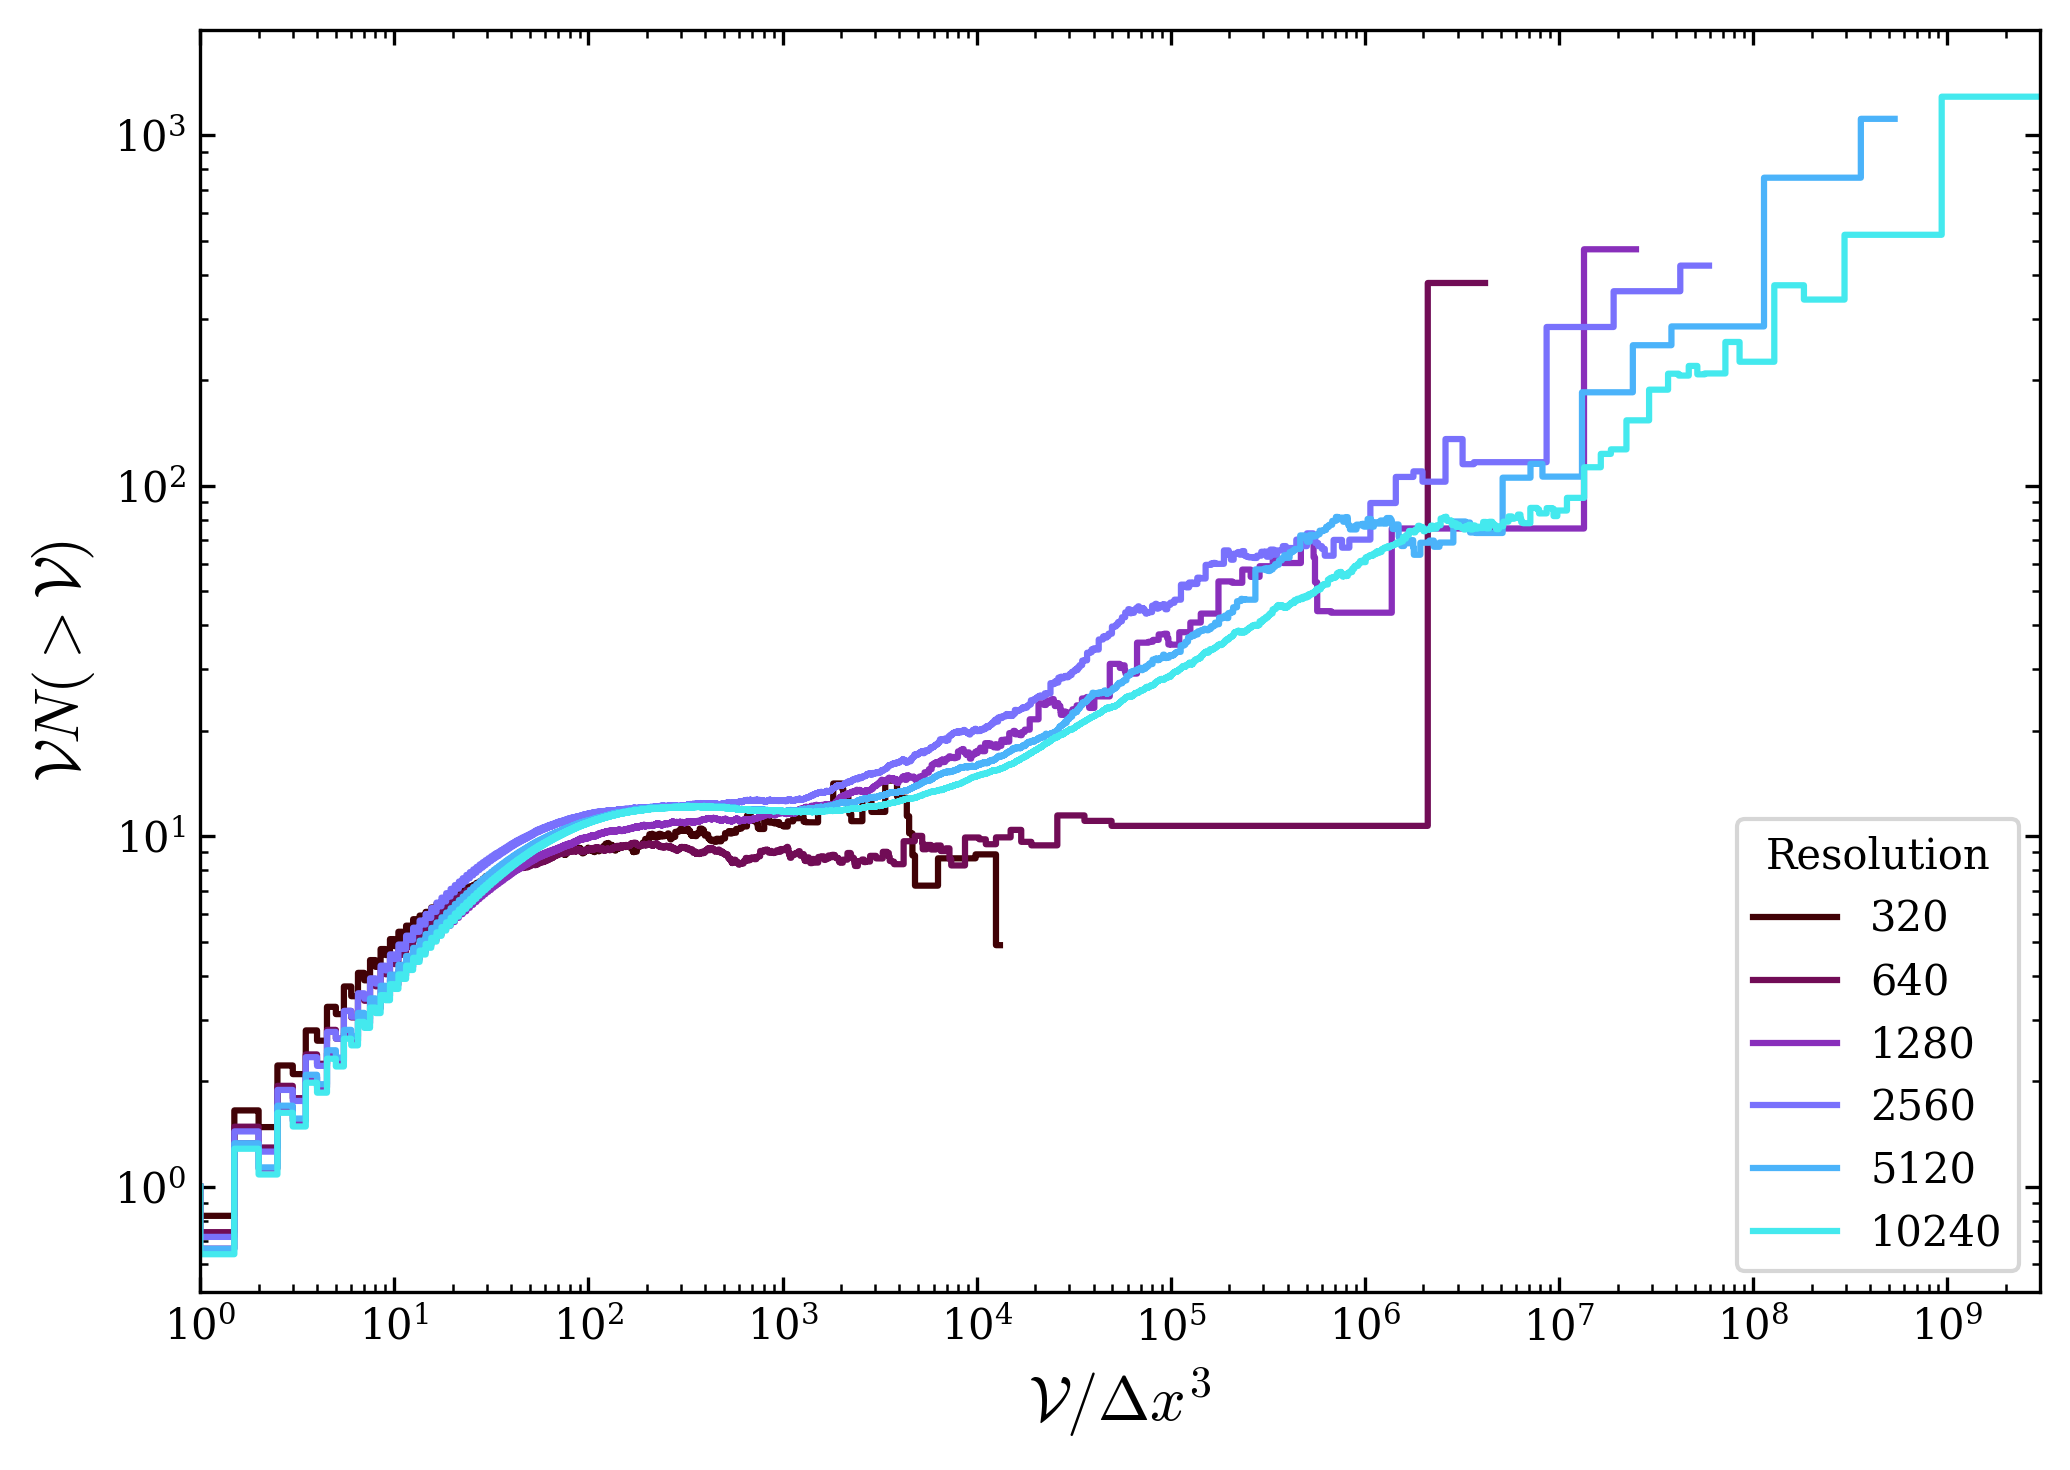

In [59]:
from pathlib import Path
import matplotlib.ticker as mticker

build_dir = Path("plots/build_up")
build_dir.mkdir(parents=True, exist_ok=True)

series = []
for res in sorted_resolutions:
    meta = summaries[res]
    color = cmr.gem(
        (np.log10(res) - np.log10(sorted_resolutions[0]))
        / (np.log10(sorted_resolutions[-1]) - np.log10(sorted_resolutions[0]))
    )
    series.append(
        {
            "label": f"{res}",
            "volumes": meta["volumes_dx"],
            "counts": meta['vn_dx']/meta['counts'][0],
            "color": color,
        }
    )

fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=300)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\mathcal{V} / \Delta x^3$", fontsize=15)
ax.set_ylabel(r"$\mathcal{V} N(>\mathcal{V})$", fontsize=15)

major_ticks = 10.0 ** np.arange(0, 9.1, 1)

ax.xaxis.set_major_locator(mticker.FixedLocator(major_ticks))
ax.xaxis.set_major_formatter(mticker.LogFormatterSciNotation())

ax.xaxis.set_minor_locator(
    mticker.LogLocator(base=10, subs=np.arange(2, 10) * 0.1, numticks=100)
)
ax.xaxis.set_minor_formatter(mticker.NullFormatter())
ax.tick_params(axis="x", which="minor", length=2)

ax.set_xlim(1,3e9)
ax.set_ylim(0.5, 2e3)  # adjust if you want a tighter y-range


for idx, entry in enumerate(series, start=1):
    ax.step(
        entry["volumes"],
        entry["counts"],
        label=entry["label"],
        color=entry["color"],
        where='mid',
    )
    ax.legend(title="Resolution", loc="lower right")
    fig.tight_layout()
    fig.savefig(build_dir / f"clump_v_cdf_deltax_build_{idx:02d}.png", dpi=300)

plt.show()


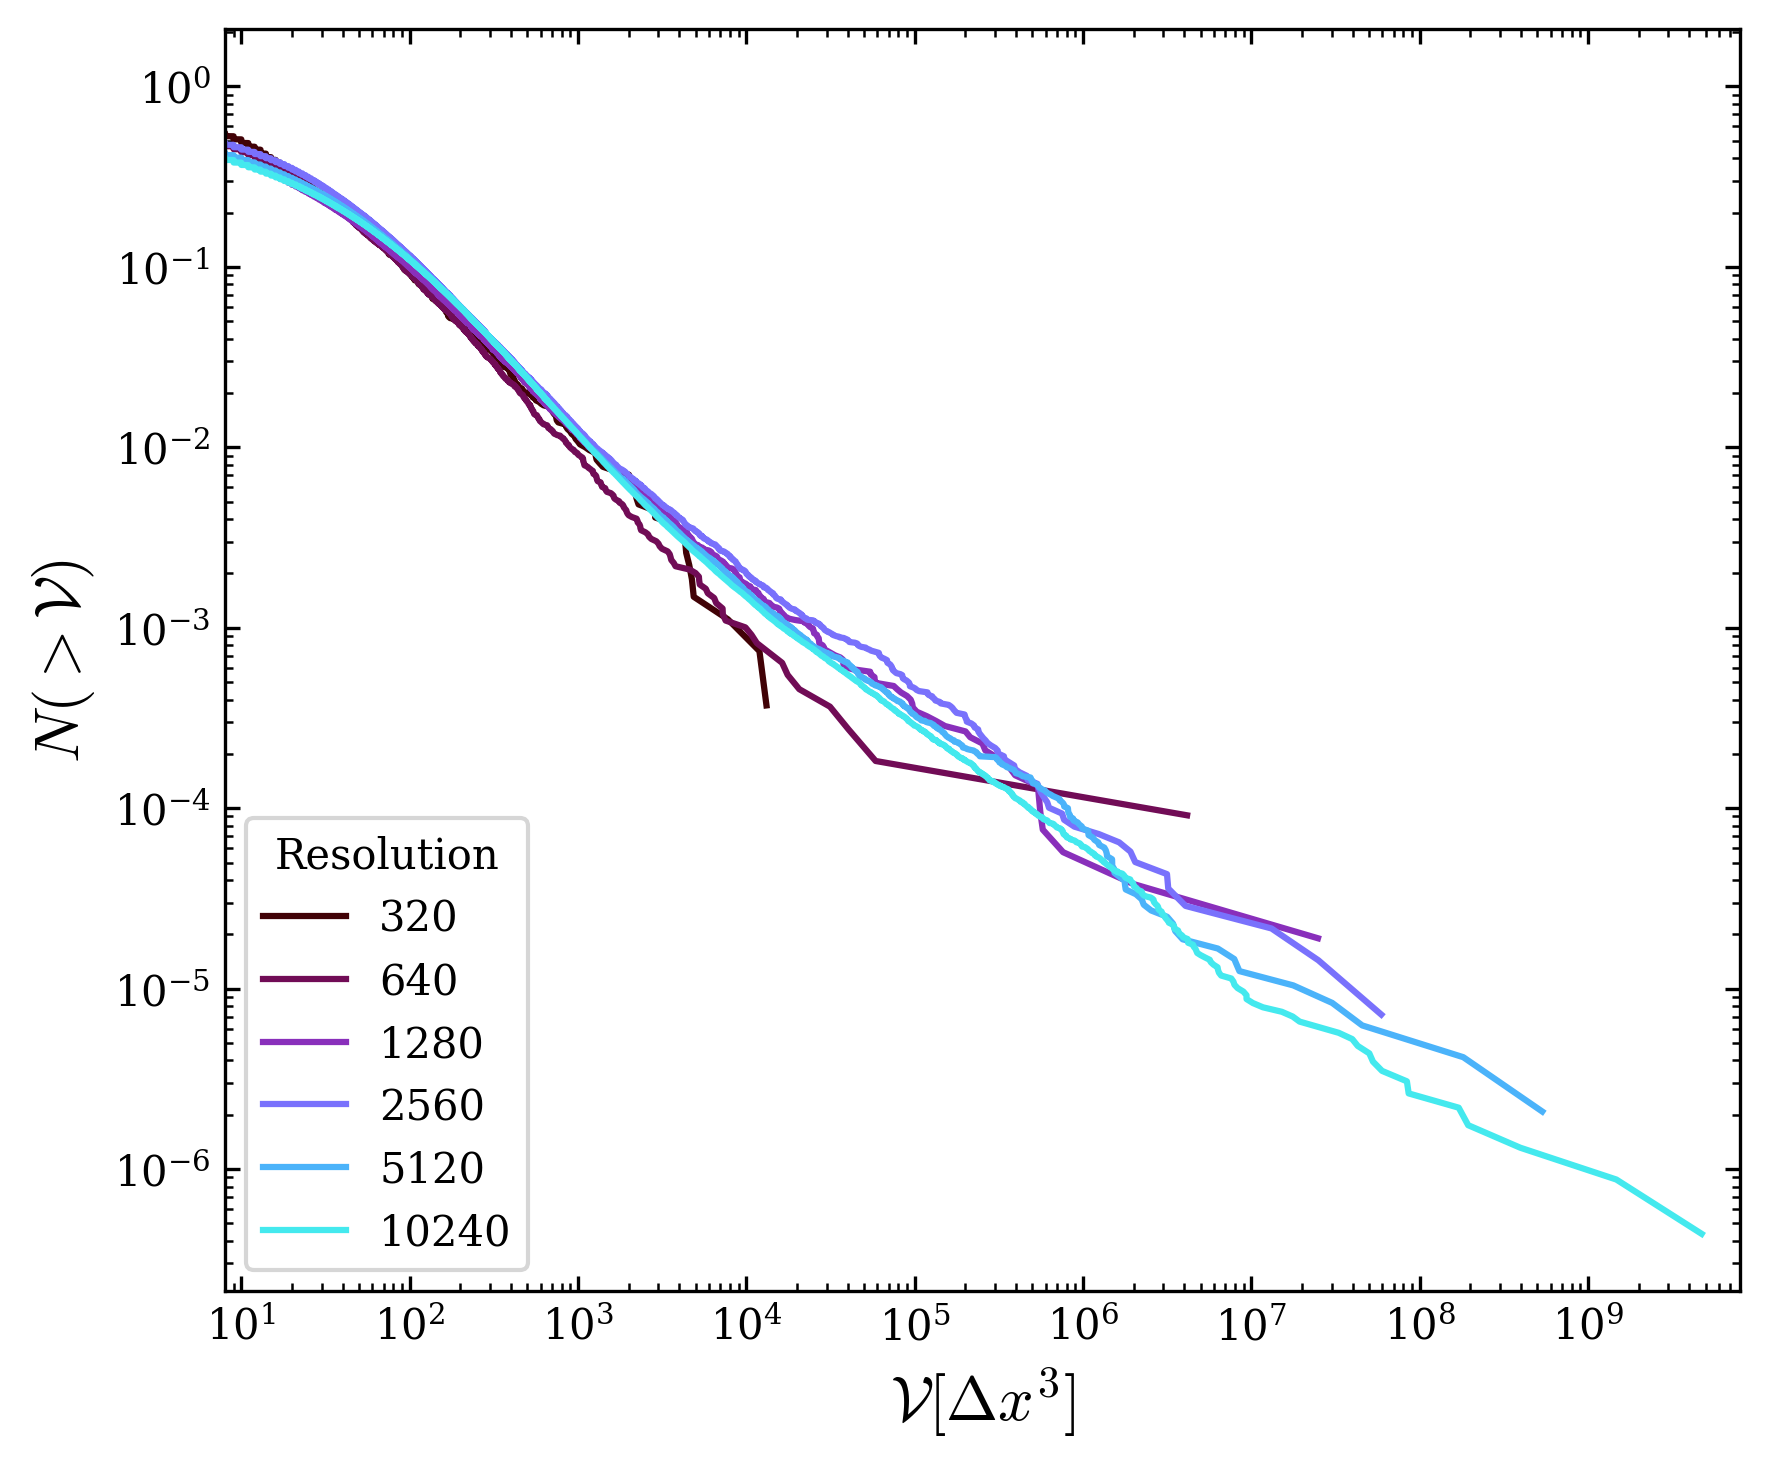

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=300)

for res in sorted_resolutions:
    meta = summaries[res]
    label = f'{res}'
    color=cmr.gem((np.log10(res) - np.log10(sorted_resolutions[0])) /
                         (np.log10(sorted_resolutions[-1]) - np.log10(sorted_resolutions[0])))

    ax.plot(meta['volumes_dx'], meta['counts']/meta['counts'][0], label=label, color=color)

ax.set_xlim(8, 8e9)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$N(>\mathcal{V})$', fontsize=15)
ax.set_xlabel(r'$\mathcal{V} [\Delta x^3]$', fontsize=15)
ax.legend(title='Resolution', loc='lower left')
fig.tight_layout()
plt.show()

## Notes

* The box length inferred from the voxel size is very close to unity for all runs (as expected for a unit cube domain).
* To add the N=10240 dataset once a matching temperature threshold run is available, extend `DATASETS` with the appropriate path and metadata and re-run the notebook cells.